In [1]:
# load libraries
import numpy as np
import pandas as pd
from pathlib import os
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedGroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import catboost as cat
import lightgbm as lgb
from typing import Union
import warnings
from dstools import mltools, edatools
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
subfile = pd.read_csv('SampleSubmission.csv')
indicators = pd.read_csv('economic_indicators.csv')

In [4]:
def feature_engineering(df):
    df_copy = df.copy()
    df_copy[['disbursement_date', 'due_date']] = df_copy[['disbursement_date', 'due_date']].astype('datetime64[ns]')

    # lender's interest rate (% profit) from loan
    df_copy['lender_int_rate'] = np.where(df_copy['Amount_Funded_By_Lender'] == 0, 0,
                                          abs((df_copy['Lender_portion_to_be_repaid'] - df_copy['Amount_Funded_By_Lender'])/\
                                              df_copy['Amount_Funded_By_Lender']*100))

    df_copy['lender_profit'] = abs(df_copy.Lender_portion_to_be_repaid - df_copy.Amount_Funded_By_Lender)

    # interest+charges amount
    df_copy['int_amt'] = abs(df_copy['Total_Amount_to_Repay'] - df_copy['Total_Amount'])
    # binary variable to show if amount repaid is less than total amount
    df_copy['loan_repay_ld_amt'] = np.where(df_copy['Total_Amount_to_Repay'] < df_copy['Total_Amount'], 1, 0)

    # interest+charges rate
    df_copy['int_rate'] = np.where(df_copy['Total_Amount'] == 0, 0, (df_copy['int_amt']/df_copy['Total_Amount'])*100)

    # Annual percentage rate (APR)
    df_copy['annual_perc_rate'] = df_copy['int_rate'] * 365 / df_copy['duration']
    df_copy['effective_int_rate'] = ((1+(df_copy['int_rate']/100)/ 365)**365 - 1)*100

    # repayment ratios
    # loan and lender ratios
    df_copy['lender_funding_to_repayment_ratio'] = np.where(
        df_copy['Lender_portion_to_be_repaid'] == 0, 0, df_copy['Amount_Funded_By_Lender'] / df_copy['Lender_portion_to_be_repaid'])

    df_copy['loan_repayment_ratio'] = np.where(
        df_copy['Total_Amount_to_Repay'] == 0, 0, df_copy['Total_Amount'] / df_copy['Total_Amount_to_Repay'])


    # extract date features
    df_copy['disbursement_month'] = df_copy['disbursement_date'].dt.month
    df_copy['due_month'] = df_copy['due_date'].dt.month
    df_copy['disbursement_year'] = df_copy['disbursement_date'].dt.year
    df_copy['due_year'] = df_copy['due_date'].dt.year
    df_copy['disbursement_wk'] = df_copy['disbursement_date'].dt.isocalendar().week
    df_copy['due_wk'] = df_copy['due_date'].dt.isocalendar().week
    df_copy['disbursement_wkday'] = df_copy['disbursement_date'].dt.weekday
    df_copy['due_wkday'] = df_copy['due_date'].dt.weekday


    # loan amount and duration group
    df_copy['loan_amount_gp'] = pd.cut(df_copy.Total_Amount, [-np.Inf, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, np.Inf], right=False,
                                       labels=['<5k', '5k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1m', '>=1m'])
    df_copy['dur_gp'] = pd.cut(df_copy.duration//30+1, [-np.Inf, 1, 6, 12, np.Inf], labels=['1m', '1-6m', '6-12m', '>12m'])

    # customer
    # num loans taken by customer
    res = df_copy.groupby(['customer_id']).tbl_loan_id.nunique()
    res.name = 'customer_tot_loans'
    df_copy = df_copy.merge(res, on=['customer_id'], how='left')

    # num loans taken by customer prior to application and disbursement
    res = df_copy.groupby(['customer_id', 'disbursement_year', 'disbursement_month']).tbl_loan_id.nunique()
    res.name = 'customer_num_loans_prior'
    df_copy = df_copy.merge(res, on=['customer_id', 'disbursement_year', 'disbursement_month'], how='left')

    # total amount and percentage of money funded by lenders for a given loan
    res = df_copy.groupby(['customer_id', 'tbl_loan_id'])[['Lender_portion_Funded', 'Amount_Funded_By_Lender', 'lender_int_rate']].sum()
    res.columns = ['tot_perc_amt_funded_by_lenders', 'tot_amt_funded_by_lenders', 'tot_int_rate_by_lenders']
    df_copy = df_copy.merge(res, on=res.index.names, how='left')

    # loan type min, average, max interest rate and amount for a customer
    res = df_copy.groupby(['customer_id', 'loan_type']).agg(
        {'int_rate' : ['min', 'mean', 'max'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'customer_loan_type_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['customer_id', 'loan_type'], how='left')

    # number of repeat loans by a customer in each country
    res = df_copy.query("New_versus_Repeat == 'Repeat Loan'").groupby(['customer_id']).agg(
        {'tbl_loan_id':'nunique'})
    res.columns = ['customer_num_repeat_loans']
    df_copy = df_copy.merge(res, on=['customer_id'], how='left')
    df_copy['customer_num_repeat_loans'] = df_copy['customer_num_repeat_loans'].fillna(0)

    # lender
    # lender min, mean, max interest rate (profit), perc funded portion, amount_funded by lender for each loan type
    # filter where lender has funded
    res = df_copy.query('Lender_portion_Funded > 0').groupby(['lender_id', 'loan_type'])[
        ['lender_int_rate', 'Lender_portion_Funded', 'Amount_Funded_By_Lender']].agg(['min', 'mean', 'max'])
    res.columns = [f'{j}_{i}' for i, j in res.columns]
    df_copy = df_copy.merge(res, on=['lender_id', 'loan_type'], how='left')

    res = df_copy.query('Lender_portion_Funded > 0').groupby(['lender_id', 'loan_type', 'disbursement_year', 'disbursement_month'])[
        ['lender_int_rate', 'Lender_portion_Funded', 'Amount_Funded_By_Lender']].agg(['min', 'mean', 'max'])
    res.columns = [f'ym_{j}_{i}' for i, j in res.columns]
    df_copy = df_copy.merge(res, on=['lender_id', 'loan_type', 'disbursement_year', 'disbursement_month'], how='left')

    # mean interest rate of lenders based on a loan type
    # overall
    res = df_copy.groupby(['lender_id', 'loan_type'], observed=True).agg(
        {'int_rate' : ['min', 'mean', 'max', 'std'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'lender_loan_type_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['lender_id', 'loan_type'],  how='left')

    # month of disbursement
    res = df_copy.groupby(['lender_id', 'loan_type', 'disbursement_year', 'disbursement_month'], observed=True).agg(
        {'int_rate' : ['min', 'mean', 'max', 'std'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'lender_loan_type_ym_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['lender_id', 'loan_type', 'disbursement_year', 'disbursement_month'],  how='left')

    # mean interest rate of lenders based on a borrower's loan amount category, loan term and type
    res = df_copy.groupby(['lender_id', 'loan_type', 'loan_amount_gp', 'dur_gp'], observed=True)[
        ['int_rate', 'lender_int_rate', 'int_amt']].mean()
    res.columns = [f'lender_loan_amt_type_term_mean_{i}' for i in res.columns]
    df_copy = df_copy.merge(res, on=['lender_id', 'loan_type', 'loan_amount_gp', 'dur_gp'],  how='left')

    # loan type
    # loan type min, average, max lender interest rate and amount
    res = df_copy.query('Lender_portion_Funded > 0').groupby(['loan_type']).agg(
        {'lender_int_rate' : ['mean', 'max', 'std'], 'lender_profit' : ['mean', 'max']}).fillna(0)
    res.columns = [f'loan_type_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['loan_type'], how='left')

    # loan type average, max interest rate and amount overall
    res = df_copy.groupby(['loan_type']).agg(
        {'int_rate' : ['mean', 'max', 'std'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'loan_type_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['loan_type'], how='left')

    # loan type average, max interest rate and amount that month of year
    res = df_copy.groupby(['loan_type', 'disbursement_year', 'disbursement_month']).agg(
        {'int_rate' : ['mean', 'max', 'std'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'loan_type_ym_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['loan_type', 'disbursement_year', 'disbursement_month'], how='left')

    # country
    #  country average, max interest rate and amount on each loan type (similar with loan type alone)
    res = df_copy.groupby(['country_id', 'loan_type', 'disbursement_year', 'disbursement_month'], observed=True).agg(
        {'int_rate' : ['min', 'mean', 'max'], 'int_amt' : ['mean', 'max']}).fillna(0)
    res.columns = [f'ym_loan_type_country_{j}_{i}' for i,j in res.columns]
    df_copy = df_copy.merge(res, on=['country_id', 'loan_type', 'disbursement_year', 'disbursement_month'], how='left')

    # number of new loans by customers in each country per month of year
    res = df_copy.query("New_versus_Repeat == 'New Loan'").groupby(
        ['country_id', 'disbursement_year', 'disbursement_month']).agg({'tbl_loan_id':'nunique'})
    res.columns = ['country_ym_num_new_loans']
    df_copy = df_copy.merge(res, on=['country_id', 'disbursement_year', 'disbursement_month'], how='left')

    # number of loans in each country per month of year
    res = df_copy.groupby(['country_id', 'disbursement_year', 'disbursement_month']).tbl_loan_id.nunique()
    res.name = 'country_num_month_loans'
    df_copy = df_copy.merge(res, on=res.index.names, how='left')


    # loan popularity in country (number of customers who have made such loan type and the frequency each loan type is made)
    loan_type_info = df_copy.groupby(['loan_type', 'country_id'])[['tbl_loan_id', 'customer_id']].nunique().rename(
    columns={'tbl_loan_id':'num_loans', 'customer_id':'num_cust'}).reset_index() # num customers in each loan type and the loan type request frequency
    # get total number of loans made in each country and the total number of customers in each country
    country_info = df_copy.groupby(['country_id'])[['tbl_loan_id', 'customer_id']].nunique().rename(
    columns={'tbl_loan_id':'tot_loans', 'customer_id':'tot_cust'}).reset_index()
    res = loan_type_info.merge(country_info, on=['country_id'], how='left')
    res = res.eval('loan_type_perc_customers = num_cust/tot_cust*100')
    res = res.eval('loan_type_perc_frequency = num_loans/tot_loans*100')

    res = res[['country_id', 'loan_type', 'loan_type_perc_customers', 'loan_type_perc_frequency']]
    df_copy = df_copy.merge(res, on=['country_id', 'loan_type'], how='left')

    return df_copy

In [5]:
df = pd.concat([train, test]).reset_index(drop=True)
df = feature_engineering(df)

In [6]:
df.head(3)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,lender_int_rate,lender_profit,int_amt,loan_repay_ld_amt,int_rate,annual_perc_rate,effective_int_rate,lender_funding_to_repayment_ratio,loan_repayment_ratio,disbursement_month,due_month,disbursement_year,due_year,disbursement_wk,due_wk,disbursement_wkday,due_wkday,loan_amount_gp,dur_gp,customer_tot_loans,customer_num_loans_prior,tot_perc_amt_funded_by_lenders,tot_amt_funded_by_lenders,tot_int_rate_by_lenders,customer_loan_type_min_int_rate,customer_loan_type_mean_int_rate,customer_loan_type_max_int_rate,customer_loan_type_mean_int_amt,customer_loan_type_max_int_amt,customer_num_repeat_loans,min_lender_int_rate,mean_lender_int_rate,max_lender_int_rate,min_Lender_portion_Funded,mean_Lender_portion_Funded,max_Lender_portion_Funded,min_Amount_Funded_By_Lender,mean_Amount_Funded_By_Lender,max_Amount_Funded_By_Lender,ym_min_lender_int_rate,ym_mean_lender_int_rate,ym_max_lender_int_rate,ym_min_Lender_portion_Funded,ym_mean_Lender_portion_Funded,ym_max_Lender_portion_Funded,ym_min_Amount_Funded_By_Lender,ym_mean_Amount_Funded_By_Lender,ym_max_Amount_Funded_By_Lender,lender_loan_type_min_int_rate,lender_loan_type_mean_int_rate,lender_loan_type_max_int_rate,lender_loan_type_std_int_rate,lender_loan_type_mean_int_amt,lender_loan_type_max_int_amt,lender_loan_type_ym_min_int_rate,lender_loan_type_ym_mean_int_rate,lender_loan_type_ym_max_int_rate,lender_loan_type_ym_std_int_rate,lender_loan_type_ym_mean_int_amt,lender_loan_type_ym_max_int_amt,lender_loan_amt_type_term_mean_int_rate,lender_loan_amt_type_term_mean_lender_int_rate,lender_loan_amt_type_term_mean_int_amt,loan_type_mean_lender_int_rate,loan_type_max_lender_int_rate,loan_type_std_lender_int_rate,loan_type_mean_lender_profit,loan_type_max_lender_profit,loan_type_mean_int_rate,loan_type_max_int_rate,loan_type_std_int_rate,loan_type_mean_int_amt,loan_type_max_int_amt,loan_type_ym_mean_int_rate,loan_type_ym_max_int_rate,loan_type_ym_std_int_rate,loan_type_ym_mean_int_amt,loan_type_ym_max_int_amt,ym_loan_type_country_min_int_rate,ym_loan_type_country_mean_int_rate,ym_loan_type_country_max_int_rate,ym_loan_type_country_mean_int_amt,ym_loan_type_country_max_int_amt,country_ym_num_new_loans,country_num_month_loans,loan_type_perc_customers,loan_type_perc_frequency
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0.0,0.124121,0.15,0.0,0,0.000000,0.000000,0.000000,0.998760,1.000000,8,9,2022,2022,35,36,1,1,5k-10k,1m,73,10,0.014305,120.85,0.124121,0.000000,0.380066,2.438560,28.561644,172.0,73.0,0.0,2.739858,177.777778,2.382087e-07,0.255226,1.168119,0.01,2238.498710,355585.5,0.000000,2.620140,117.460317,4.222527e-07,0.262645,0.600000,0.01,2450.734346,89082.0,0.0,1.712628,118.095238,4.866403,152.775142,93419.0,0.000000,1.991372,118.095238,6.070031,182.393127,36379.0,1.382983,2.049030,98.740052,2.739858,177.777778,10.089500,35.818438,46709.5,1.712628,118.095238,4.866403,152.775142,93419.0,1.991372,118.095238,6.070031,182.393127,36379.0,0.000000,1.991372,118.095238,182.393127,36379.0,68.0,16653,78.177778,93.494906
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0.0,0.328249,25.50,84.0,0,0.324387,16.914462,0.324912,0.996728,0.996767,7,8,2022,2022,30,31,5,5,10k-50k,1m,23,5,0.300000,7768.50,0.328249,0.000000,0.097133,0.705882,23.173913,230.0,23.0,0.0,2.739858,177.777778,2.382087e-07,0.255226,1.168119,0.01,2238.498710,355585.5,0.000000,1.349556,44.141862,3.000000e-01,0.305269,1.168119,30.00,3406.525962,355585.5,0.0,1.712628,118.095238,4.866403,152.775142,93419.0,0.000000,1.318115,44.141862,2.432311,144.484026,93419.0,1.627019,2.320579,330.214786,2.739858,177.777778,10.089500,35.818438,46709.5,1.712628,118.095238,4

In [7]:
# preprocess economic indicators
indicator_pivot = (
    indicators
    .melt(id_vars=['Country','Indicator'], var_name='year')
    .pivot(index=['Country', 'year'], columns= ['Indicator']))

indicator_pivot.columns = [j for _, j in indicator_pivot.columns]

indicator_pivot.columns = (indicator_pivot.columns
                           .str.extract(r'^([a-zA-Z\s,]+)', expand=False)
                           .str.strip()
                           .str.replace(',', '')
                           .str.replace(' ', '_')
                           )

indicator_pivot = indicator_pivot.reset_index()
indicator_pivot['year'] = indicator_pivot['year'].str.replace('YR', '').astype(int)

kenya_ghana_info = indicator_pivot.query(f'Country in {["Kenya", "Ghana"]}').reset_index(drop=True)

# adding 2024 data
kenya_ghana_info = pd.concat([kenya_ghana_info, 
                              pd.DataFrame({'Country':['Kenya', 'Ghana'], 'year':[2024, 2024]})], 
                              ignore_index=True)

# get economic indicators of interest
eco_ind_cols = ['Deposit_interest_rate', 'Inflation_consumer_prices', 'Official_exchange_rate', 'Unemployment_rate']

In [8]:
def add_economic_indicators(data, indicator_df, indicator_cols:list=None, add=True, add_diff=False, drop_raw=False):
    """
    Adds economic indicators to input dataset
    """
    indicator_df_copy = indicator_df.copy()
    data_copy = data.copy()
    if not add:
        return data_copy
    elif add:
        indicator_df_copy = (
            indicator_df_copy.groupby(['Country'])
            .apply(lambda x: x.infer_objects(copy=False).ffill(), include_groups=False)
            .reset_index(level=0)
        )
        if indicator_cols is not None:
            indicator_df_copy = indicator_df_copy[['Country', 'year']+indicator_cols].rename(
                columns={'Country':'country_id', 'year':'disbursement_year'})
        else:
            indicator_df_copy = indicator_df_copy.rename(columns={'Country':'country_id', 'year':'disbursement_year'})

        if add_diff:
            temp = []
            country_col = indicator_df_copy.filter(regex='[cC]ountry').columns[0]
            for country in indicator_df_copy[country_col].unique():
                select_df = indicator_df_copy.query(f'{country_col} == "{country}"').ffill()
                diff = select_df[indicator_cols].agg(['diff', 'pct_change'])
                diff.columns = [f'{i}_{j}' for i,j in diff.columns]
                select_df = pd.concat([select_df, diff], axis=1)
                temp.append(select_df)
            temp = pd.concat(temp)
            if drop_raw:
                return data_copy.merge(temp, on=['country_id', 'disbursement_year'], how='left').drop(columns=indicator_cols)
            else:
                return data_copy.merge(temp, on=['country_id', 'disbursement_year'], how='left')
        else:
            return data.merge(indicator_df_copy, on=['country_id', 'disbursement_year'], how='left')

In [9]:
# split back to train and test datasets
train = df.query('target.notnull()').reset_index(drop=True)
test = df.query('target.isnull()').reset_index(drop=True)

In [10]:
# adding economic indicators
train_c = add_economic_indicators(train, kenya_ghana_info, eco_ind_cols, add=False, add_diff=True, drop_raw=False)
test_c = add_economic_indicators(test, kenya_ghana_info, eco_ind_cols, add=False, add_diff=True, drop_raw=False)

In [11]:
target = train.target.astype(int)

In [12]:
# drop columns
drop_cols = pd.Index(['country_id', 'ID', 'customer_id', 'tbl_loan_id', 'loan_amount_gp', 'dur_gp',
                      'target', 'due_date', 'disbursement_date']) #, 'lender_id', 'loan_type'


new_cols = ['New_versus_Repeat', 'due_year', 'due_month', 'disbursement_month',
            'due_wk', 'disbursement_wk','due_wkday', 'disbursement_wkday',
            'disbursement_year', 'loan_type_perc_frequency', 'loan_type_perc_customers']

In [13]:
skew = train.drop(columns=drop_cols.tolist()+new_cols).select_dtypes('number').skew()

skew = skew[skew.abs().sort_values().index]

In [14]:
def preprocess_data(df_c, transform=False):
    df_copy = df_c.copy()
    if transform:
        sqrt_cols = skew[(skew.abs() > 3) & (skew.abs() <= 10)].index
        log_cols = skew[(skew.abs() > 10)].index

        df_copy[sqrt_cols] = np.sqrt(df_copy[sqrt_cols])
        df_copy[log_cols] = np.log10(1+df_copy[log_cols])
    
    df_copy.New_versus_Repeat = df_copy.New_versus_Repeat.str.replace(' Loan', '').map({'Repeat':0, 'New':1})

    if 'lender_id' in df_copy.columns.tolist():
        for i in df.lender_id.unique():
            df_copy[f'lender_{i}'] = np.where(df_copy['lender_id'] == i, 1, 0)
        df_copy = df_copy.drop('lender_id', axis=1)

    if 'loan_type' in df_copy.columns:
        unique_loan_types = np.unique(df.loan_type).tolist()
        for i in unique_loan_types:
            df_copy[f'loan_type_{i}'] = np.where(df_copy['loan_type'] == i, 1, 0)
        df_copy = df_copy.drop('loan_type', axis=1)
    df_copy = df_copy.reset_index(drop=True)
    return df_copy

In [15]:
def split_customers(train_data, frac:Union[list, tuple, float]=[0.8, 0.5], 
                    seed=83, n_splits=3, shuffle=True):
    """
    Splits customers into groups and assigns them to train and test or validation sets. Customer found in only one dataset
    Returns a list of customers in each dataset
    """
    if isinstance(frac, (list, tuple)):
        assert len(frac) == (n_splits-1), 'Length of frac must be one less than n_splits'
    else: 
        assert len([frac]) == (n_splits-1), 'Length of frac must be one less than n_splits'
    customer_ids = train_data['customer_id'].drop_duplicates().tolist()
    if shuffle:
        rng = np.random.RandomState(seed)
        customer_ids = rng.permutation(customer_ids)
    if n_splits == 2:
        train_samples = int(len(customer_ids) * frac)
        train_cust = customer_ids[:train_samples]
        test_cust = customer_ids[train_samples:]
        return train_cust, test_cust
    elif n_splits == 3:
        train_samples = int(len(customer_ids) * frac[0])
        test_samples = int((len(customer_ids)-train_samples) * frac[1])
        train_cust = customer_ids[:train_samples]
        test_cust = customer_ids[train_samples:(train_samples+test_samples)]
        val_cust = customer_ids[(train_samples+test_samples):]
        return train_cust, test_cust, val_cust

In [16]:
# get groups
group_stratify = False
n_splits = 2
if group_stratify:
  skfold = StratifiedGroupKFold(shuffle=True, random_state=94)
  if n_splits == 2:
    train_groups, val_groups = split_customers(train, frac=0.75, n_splits=n_splits)
    train_idx, val_idx = train.customer_id.isin(train_groups), train.customer_id.isin(val_groups)
  elif n_splits == 3:
    train_groups, test_groups, val_groups = split_customers(train, frac=[0.75, 0.5], n_splits=n_splits)
    train_idx, test_idx, val_idx = train.customer_id.isin(train_groups), train.customer_id.isin(test_groups), train.customer_id.isin(val_groups)
else:
  skfold = StratifiedKFold(shuffle=True, random_state=94)
  if n_splits == 2:
    train_idx, val_idx = train_test_split(np.arange(len(train)), train_size=0.75, random_state=83, stratify=target)
  elif n_splits == 3:
    train_idx, test_val_idx = train_test_split(np.arange(len(train)), train_size=0.75, random_state=83, stratify=target)
    test_idx, val_idx = train_test_split(np.arange(len(test_val_idx)), train_size=0.5, random_state=83, stratify=target.values[test_val_idx])

test_ids = test.loc[test_c.index, 'ID'].values

In [17]:
# drop features
train_c = train_c.drop(columns=drop_cols.tolist())
test_c = test_c.drop(columns=drop_cols.tolist()) #drop('loan_type')


train_c = preprocess_data(train_c, transform=False)
test_c = preprocess_data(test_c, transform=False)

In [18]:
# variables
cols = train_c.columns

if n_splits == 2:
    Xtrain, ytrain = train_c.loc[train_idx], target.loc[train_idx]
    Xvalid, yvalid = train_c.loc[val_idx], target.loc[val_idx]
    print(Xtrain.shape, Xvalid.shape)
    print(np.bincount(ytrain)/len(ytrain), np.bincount(yvalid)/len(yvalid))
elif n_splits == 3:
    Xtrain, ytrain = train_c.loc[train_idx], target.loc[train_idx]
    Xtest, ytest = train_c.loc[test_idx], target.loc[test_idx]
    Xvalid, yvalid = train_c.loc[val_idx], target.loc[val_idx]
    print(Xtrain.shape, Xtest.shape, Xvalid.shape)
    print(np.bincount(ytrain)/len(ytrain), np.bincount(yvalid)/len(yvalid), np.bincount(ytest)/len(ytest))

(51490, 124) (17164, 124)
[0.98168576 0.01831424] [0.98164763 0.01835237]


In [19]:
lgbm = lgb.LGBMClassifier(random_state=123, n_estimators=1000, learning_rate=0.03, num_leaves=32, min_child_samples=10,
                          reg_alpha=1, importance_type='gain', colsample_bytree=0.3, subsample=0.8, verbose=-1)

rf = RandomForestClassifier(n_estimators=300, n_jobs=2, min_samples_leaf=2, min_samples_split=3,
                            random_state=123, max_features=0.4, criterion='entropy', max_samples=0.8)

catm = cat.CatBoostClassifier(n_estimators=1300, learning_rate=0.05, reg_lambda=5, bootstrap_type='Bernoulli', 
                              random_seed = 123, early_stopping_rounds=None, rsm=0.4, subsample=0.8, 
                              silent=True, eval_metric='F1', thread_count=2)

__Model Training__

In [20]:
model = mltools.Model()

In [21]:
model.train(rf, Xtrain, ytrain);

In [22]:
model.train(lgbm, Xtrain, ytrain)

LGBMClassifier(colsample_bytree=0.3, importance_type='gain', learning_rate=0.03,
               min_child_samples=10, n_estimators=1000, num_leaves=32,
               random_state=123, reg_alpha=1, subsample=0.8, verbose=-1)

In [23]:
model.train(catm, Xtrain, ytrain);

__Model Evaluation__

In [24]:
mltools.print_classification_report(rf, Xtrain, ytrain, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     50547
 Default-Yes       0.99      0.97      0.98       943

    accuracy                           1.00     51490
   macro avg       1.00      0.99      0.99     51490
weighted avg       1.00      1.00      1.00     51490



In [25]:
mltools.print_classification_report(lgbm, Xtrain, ytrain, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     50547
 Default-Yes       1.00      1.00      1.00       943

    accuracy                           1.00     51490
   macro avg       1.00      1.00      1.00     51490
weighted avg       1.00      1.00      1.00     51490



In [26]:
mltools.print_classification_report(catm, Xtrain, ytrain, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     50547
 Default-Yes       1.00      0.99      0.99       943

    accuracy                           1.00     51490
   macro avg       1.00      1.00      1.00     51490
weighted avg       1.00      1.00      1.00     51490



In [27]:
mltools.print_classification_report(rf, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     16849
 Default-Yes       0.92      0.86      0.89       315

    accuracy                           1.00     17164
   macro avg       0.96      0.93      0.94     17164
weighted avg       1.00      1.00      1.00     17164



In [28]:
mltools.print_classification_report(lgbm, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     16849
 Default-Yes       0.93      0.89      0.91       315

    accuracy                           1.00     17164
   macro avg       0.96      0.94      0.95     17164
weighted avg       1.00      1.00      1.00     17164



In [29]:
mltools.print_classification_report(catm, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

              precision    recall  f1-score   support

  Default-No       1.00      1.00      1.00     16849
 Default-Yes       0.93      0.89      0.91       315

    accuracy                           1.00     17164
   macro avg       0.96      0.94      0.95     17164
weighted avg       1.00      1.00      1.00     17164



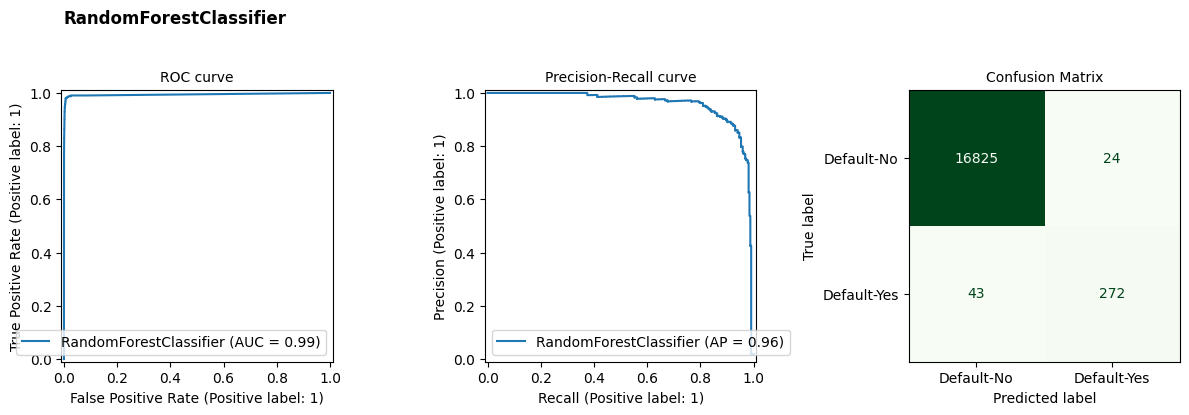

In [30]:
mltools.classification_performance_chart_report(rf, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

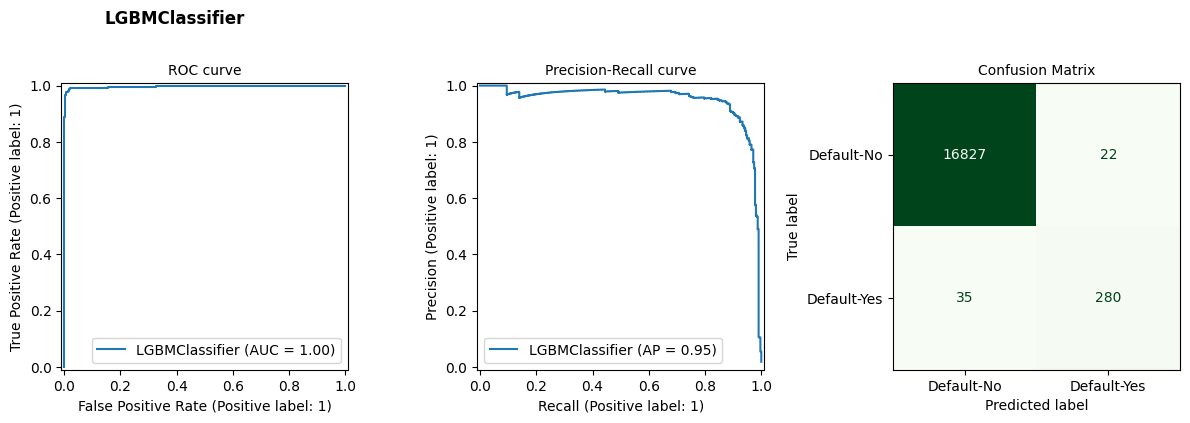

In [31]:
mltools.classification_performance_chart_report(lgbm, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

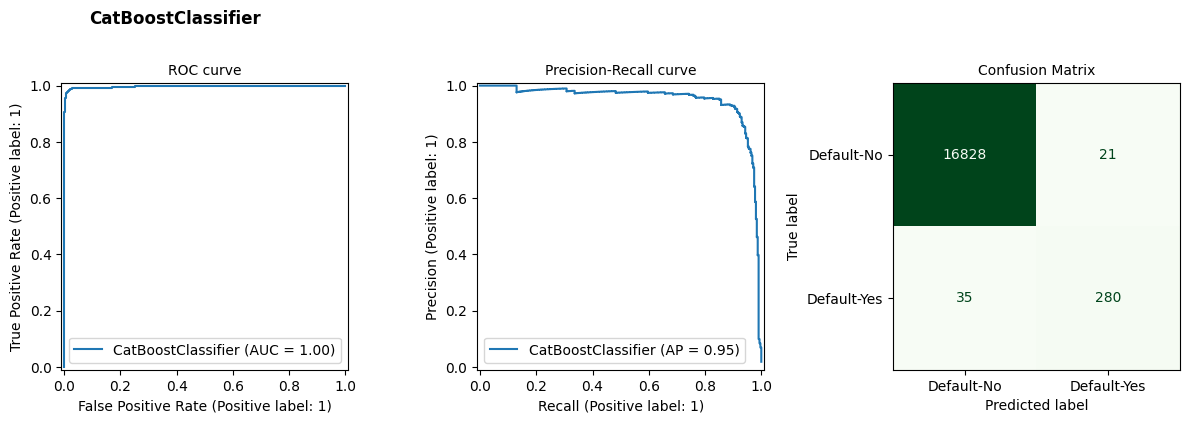

In [32]:
mltools.classification_performance_chart_report(catm, Xvalid, yvalid, ['Default-No', 'Default-Yes'])

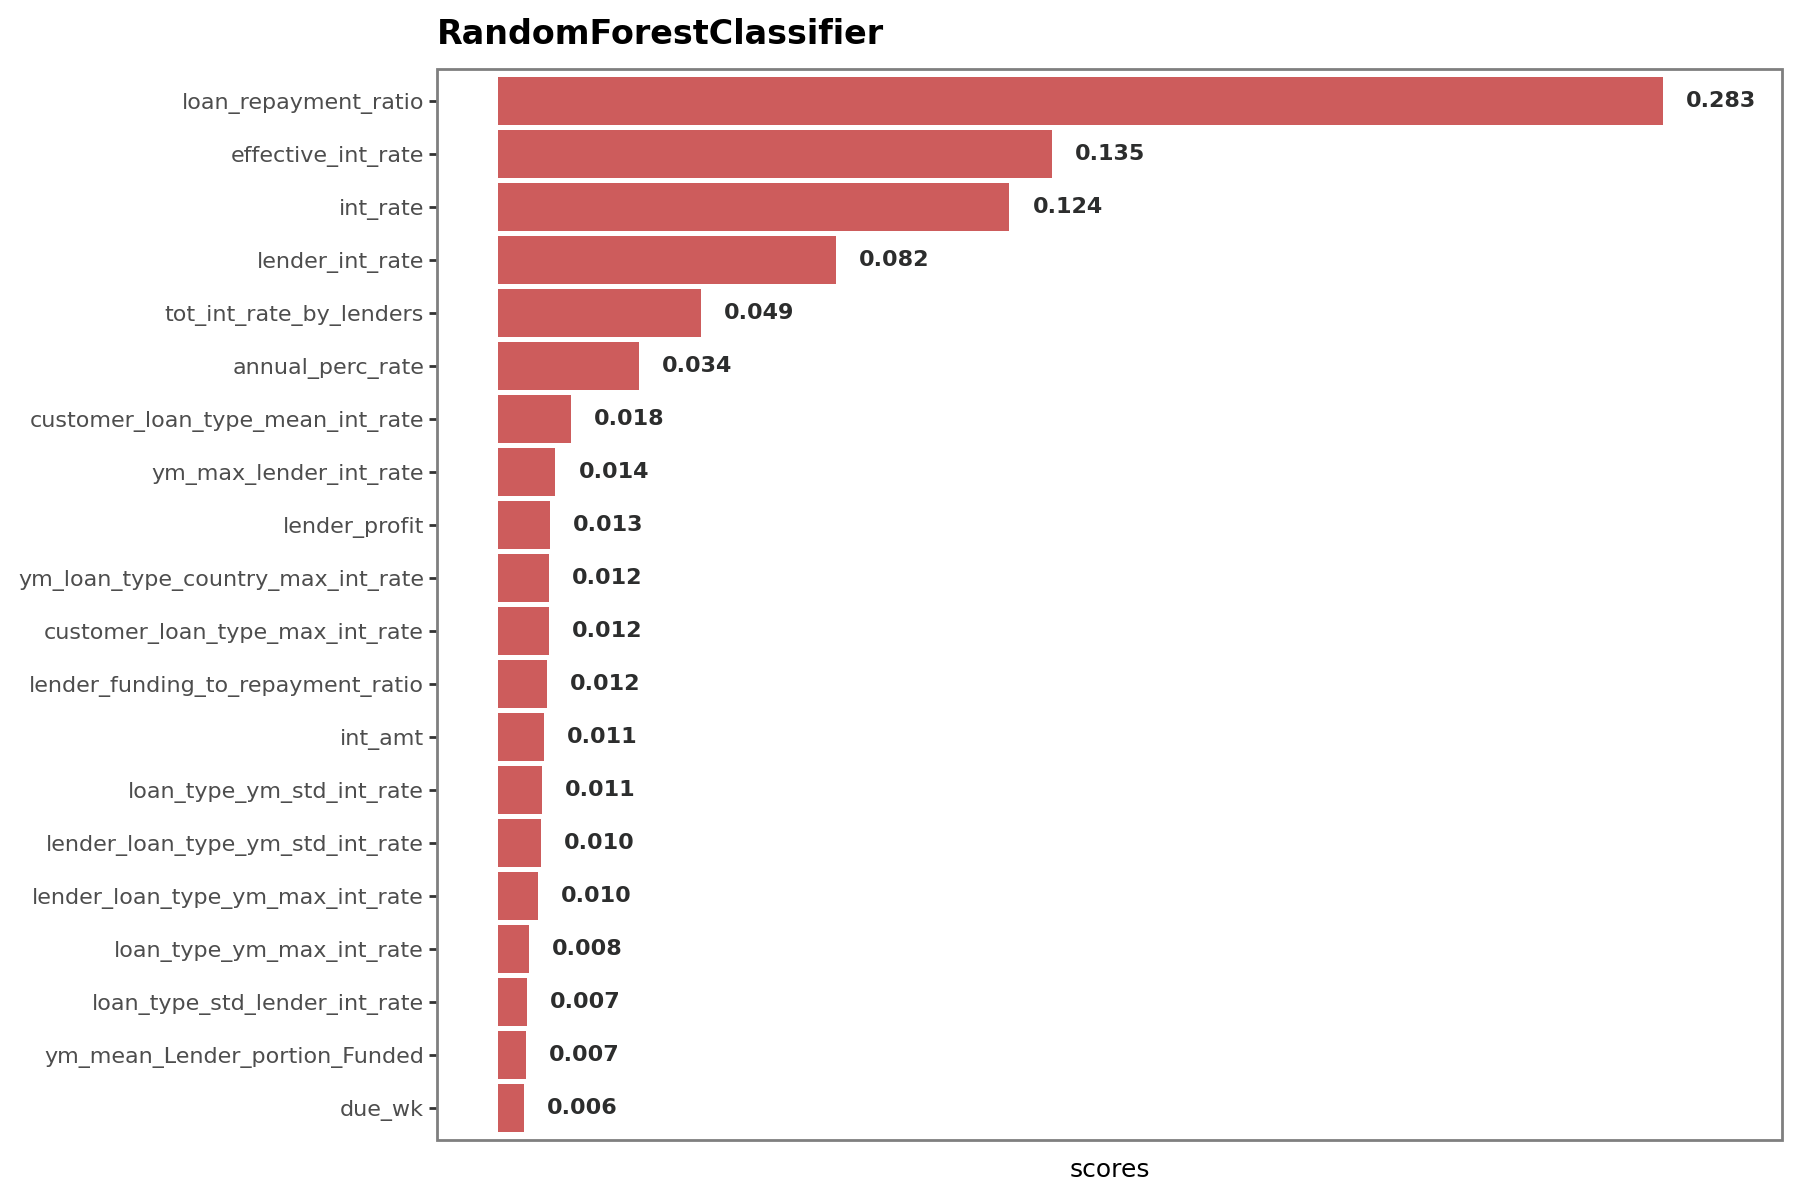

In [33]:
mltools.topn_importance(rf)

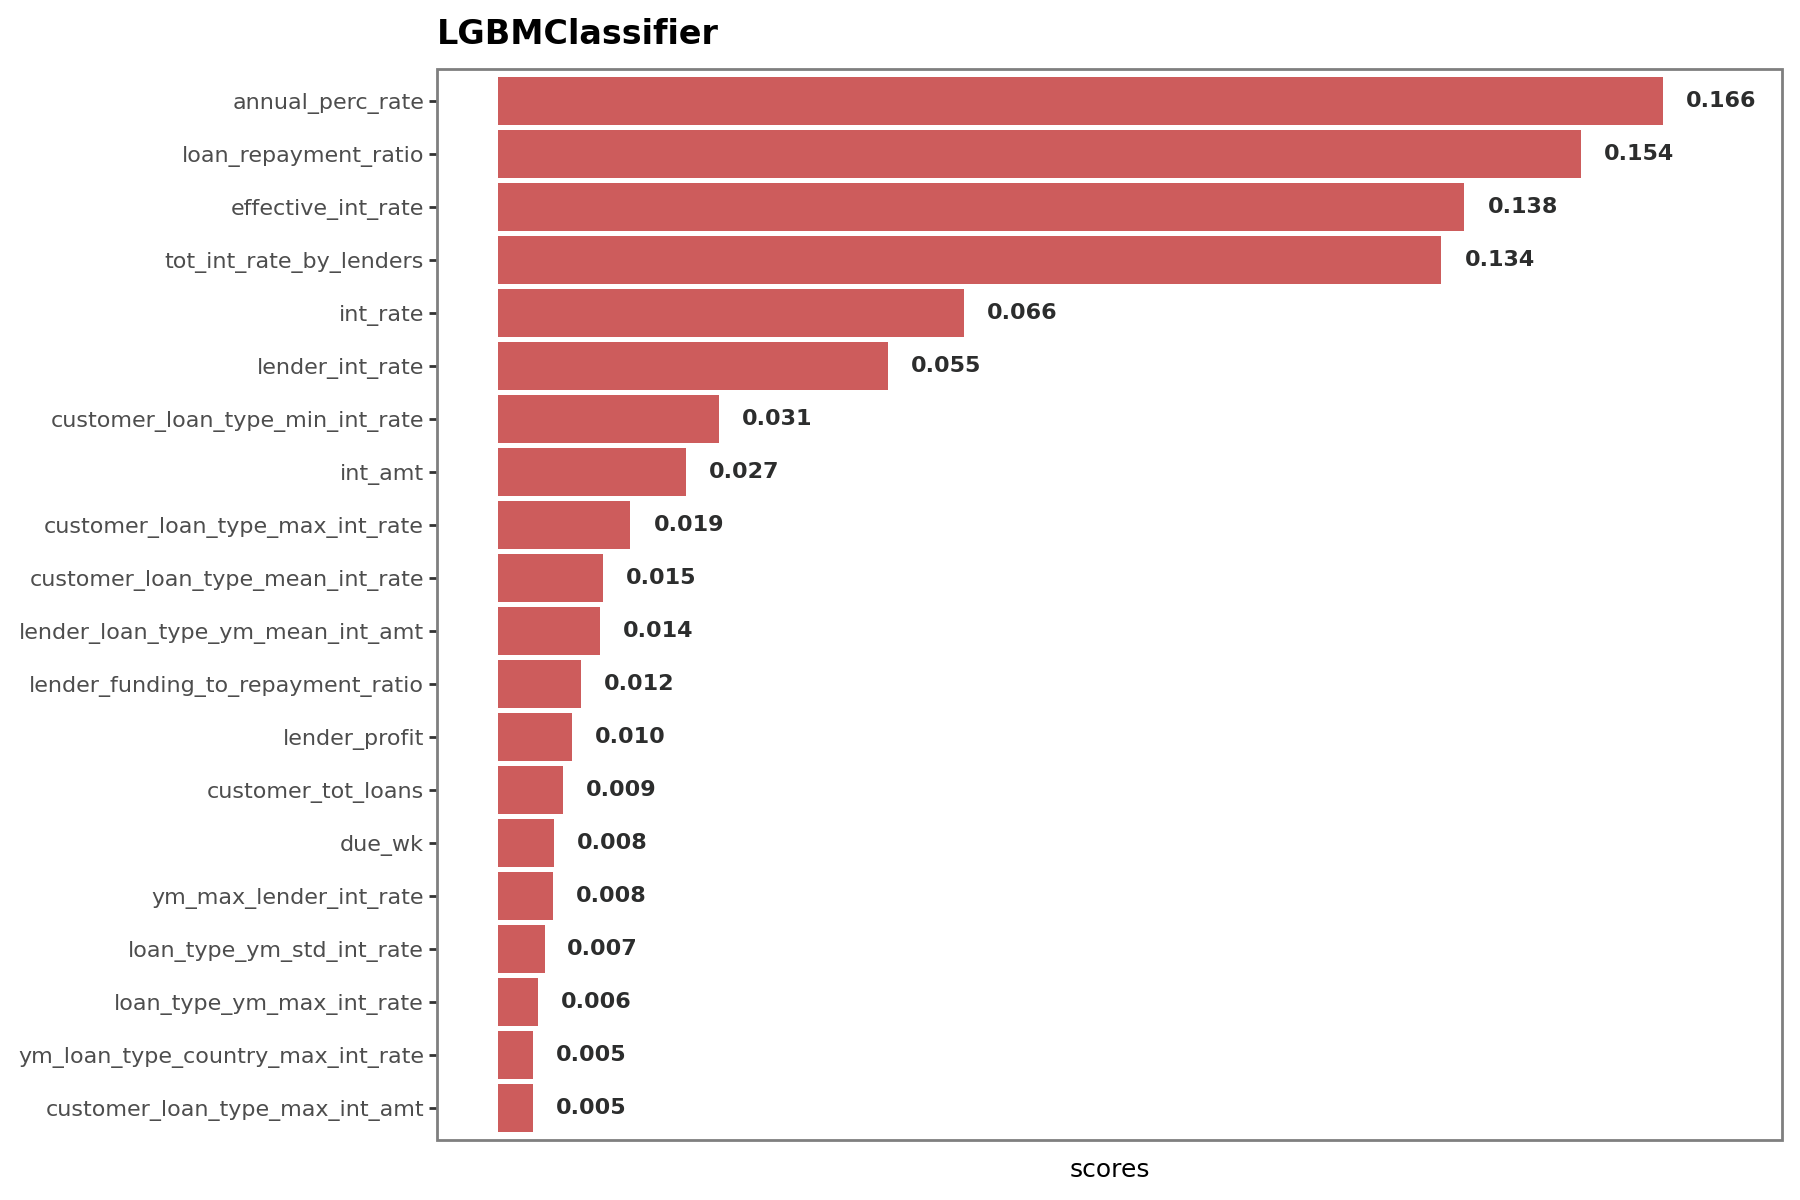

In [34]:
mltools.topn_importance(lgbm)

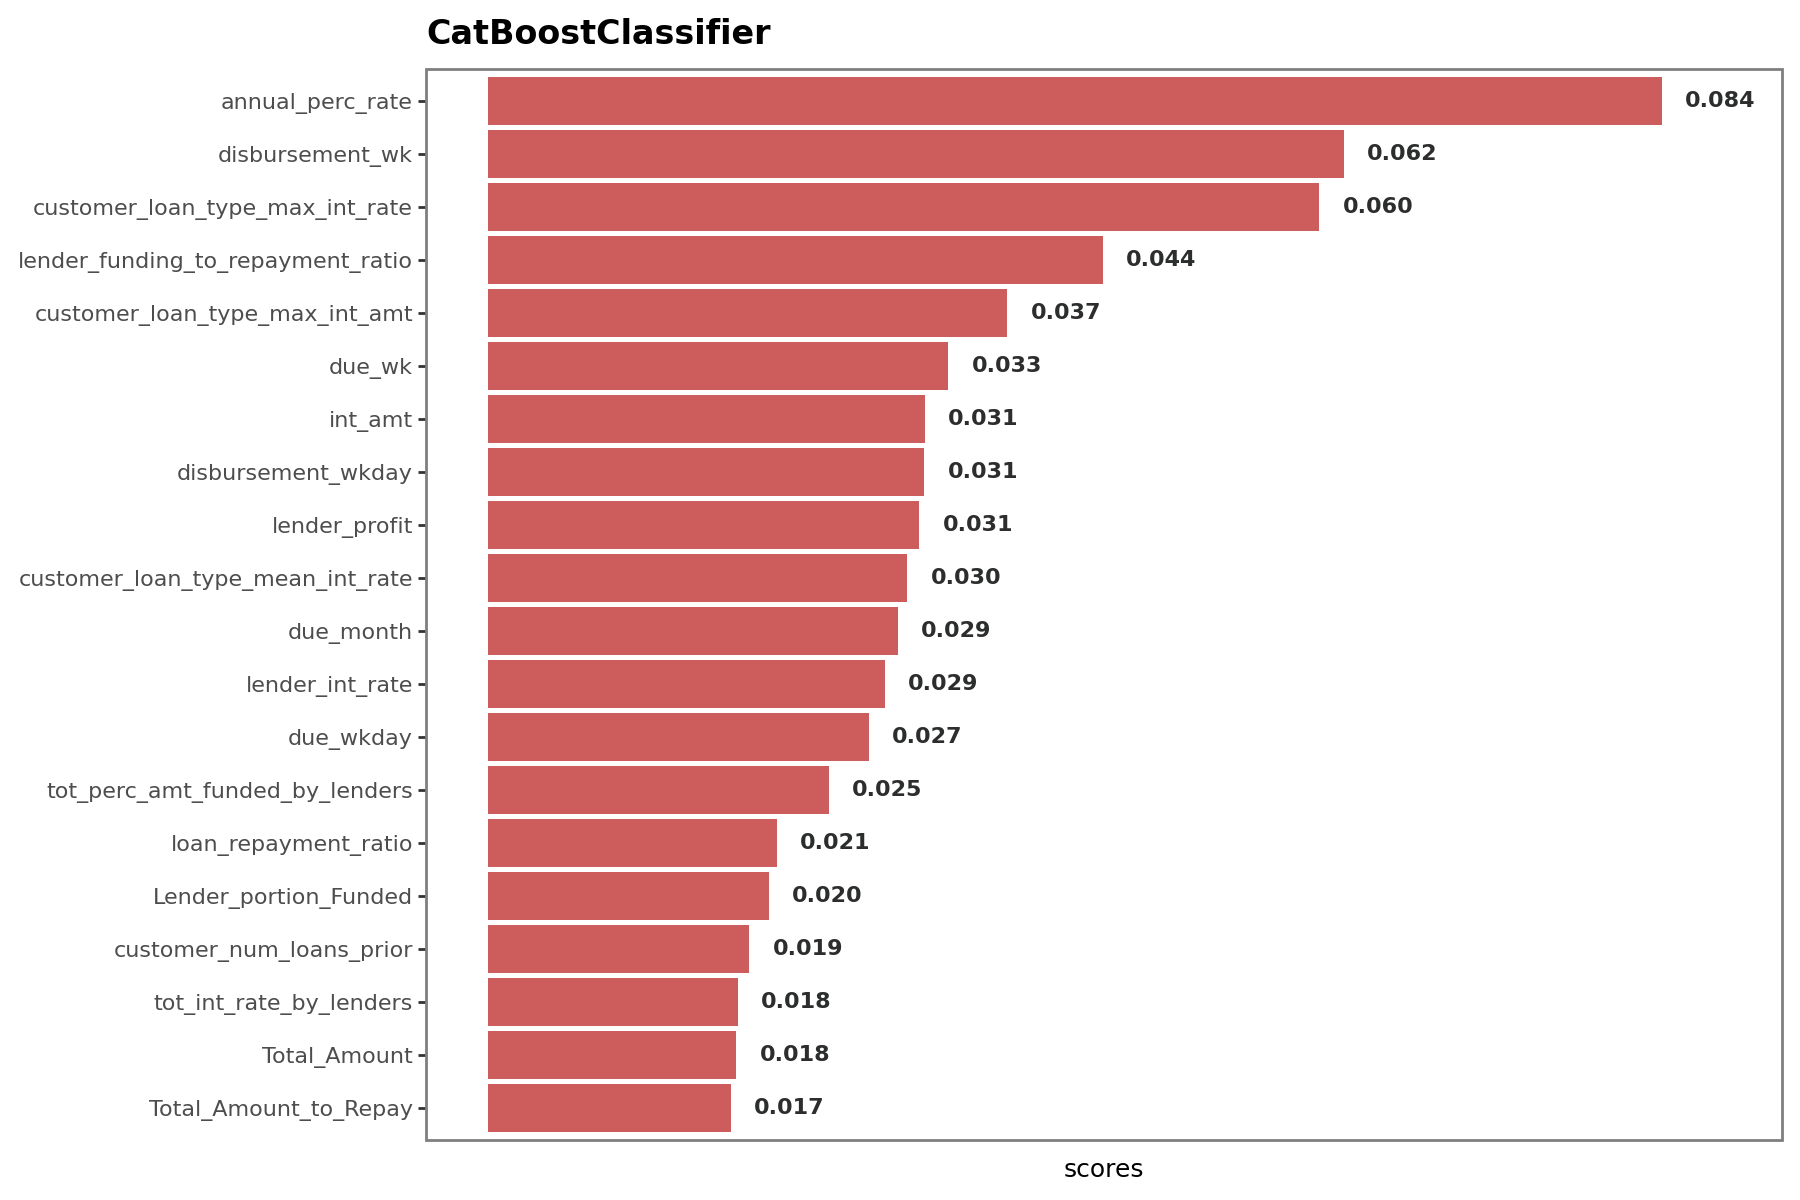

In [35]:
mltools.topn_importance(catm)

In [36]:
mltools.classification_eval_metrics(rf, Xvalid, yvalid)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.996096,0.994165,0.863492,0.918919,0.890344,0.998576


In [37]:
mltools.classification_eval_metrics(lgbm, Xvalid, yvalid)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.996679,0.997235,0.888889,0.927152,0.907618,0.998694


In [38]:
mltools.classification_eval_metrics(catm, Xvalid, yvalid)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.996737,0.997229,0.888889,0.930233,0.909091,0.998754


__Test predictions__

In [39]:
test_preds = np.column_stack(list(map(lambda x: x.predict(test_c), [rf, lgbm, catm])))

In [40]:
list(map(lambda x: np.bincount(x),test_preds.T))

[array([17886,   708], dtype=int64),
 array([17967,   627], dtype=int64),
 array([17892,   702], dtype=int64)]

In [41]:
test_probas = np.column_stack(list(map(lambda x: x.predict_proba(test_c)[:, 1], [rf, lgbm, catm])))

In [42]:
def get_mode(x:list):
    if isinstance(x, (np.ndarray, pd.DataFrame)):
        x = list(x)
    uniq_value = np.unique(x)
    mode_vals = list(map(lambda i: x.count(i), uniq_value))
    mode_val = uniq_value[np.array(mode_vals).argmax()]
    return mode_val

In [43]:
hard_votes = list(map(lambda x: get_mode(x), test_preds))
wt_votes = 1*(np.average(test_probas, weights=np.array([0.35, 0.3, 0.35]), axis=1) > 0.5)
soft_votes = np.where(test_probas.mean(1) > 0.5, 1, 0)

In [44]:
np.bincount(hard_votes), np.bincount(soft_votes), np.bincount(wt_votes)

(array([17895,   699], dtype=int64),
 array([17897,   697], dtype=int64),
 array([17895,   699], dtype=int64))

In [45]:
def save_predictions(preds, filename):
    test_results = subfile.copy()
    test_results['ID'] = test_ids
    test_results['target'] = preds

    test_results.to_csv(f'{filename}.csv', index=False)
    print(f'{filename} saved!')

In [46]:
for x,y in zip(test_preds.T, ['new_preds/rf_latest', 'new_preds/lgbm_latest', 'new_preds/catm_latest']):
    save_predictions(x, y)

new_preds/rf_latest saved!
new_preds/lgbm_latest saved!
new_preds/catm_latest saved!


In [47]:
for x,y in zip([hard_votes, soft_votes, wt_votes], ['new_preds/hv_latest', 'new_preds/sv_latest', 'new_preds/wtv_latest']):
    save_predictions(x, y)

new_preds/hv_latest saved!
new_preds/sv_latest saved!
new_preds/wtv_latest saved!


__Cross validation__

In [ ]:
if group_stratify:
    groups = train.customer_id.loc[np.r_[train_idx, val_idx]].values
else:
    groups = None

In [49]:
X = pd.concat([Xtrain, Xvalid], ignore_index=True)
y = pd.concat([ytrain, yvalid], ignore_index=True)

In [50]:
for model in [rf, lgbm, catm]:
    print(model.__class__.__name__+'\n======================================')
    cvs_scores = cross_val_score(model, X, y, scoring='f1', cv=skfold, groups=groups, n_jobs=2)
    print(cvs_scores.round(5))
    print(f'Mean + sd: {cvs_scores.mean():.4f} +- {cvs_scores.std():.4f}\n')

RandomForestClassifier
[0.8815  0.88935 0.89916 0.90309 0.91129]
Mean + sd: 0.8969 +- 0.0104

LGBMClassifier
[0.86475 0.91057 0.9106  0.9002  0.9022 ]
Mean + sd: 0.8977 +- 0.0170

CatBoostClassifier
[0.88755 0.89669 0.9125  0.89837 0.89861]
Mean + sd: 0.8987 +- 0.0080

